In [1]:
# IMPORTS

# tensorflow
import tensorflow as tf

# other
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
# config
model_path = 'model.h5'
images_folder = './test_v2/'

## RLE

In [38]:
# creates a photo from RLE
def RLE_decoder(RLE:str, size=(768, 768)):  
    segmented_photo = np.zeros((size[0] * size[1]))  # 1D array for black image
    if RLE == None:
        return tf.image.transpose(np.reshape(segmented_photo, (size[0], size[1], 1)))
    RLE = [int(x) for x in RLE.split(' ')]  # get RLE indices
    for idx in range(0, len(RLE), 2):  # change segmented pixels
        segmented_photo[ RLE[idx] : RLE[idx]+RLE[idx+1] ] = 1
    segmented_photo = np.transpose(np.reshape(segmented_photo, (size[0], size[1], 1)), (1,0,2))  
    return segmented_photo

# creates a RLE from photo
def RLE_encoder(segmented_photo): 
    # transpose and flatten
    segmented_photo = np.transpose(segmented_photo, (1,0,2))
    segmented_photo = segmented_photo.flatten() > 0.5  # segmented pixels count if its value > 0.5
    
    # calculate RLE
    RLE_count = [0]
    RLE_index = [0]
    last_pixel = False
    for idx in range(len(segmented_photo)):
        pixel = segmented_photo[idx]
        if pixel == last_pixel:  
            RLE_count[-1] += 1
        else:
            RLE_count.append(1)
            RLE_index.append(idx)
            last_pixel = not last_pixel

    # convert RLE to string
    RLE = ''
    for idx in range(1,len(RLE_count), 2):
        if RLE != '':
            RLE += ' '
        RLE += f'{RLE_index[idx]} {RLE_count[idx]}'
    return RLE

## Load model

In [4]:
model = tf.keras.models.load_model(model_path, compile=False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 768, 768, 8)  224         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 768, 768, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 conv2d_10 (Conv2D)             (None, 384, 384, 16  4624        ['concatenate_1[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 384, 384, 16  64         ['conv2d_10[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 384, 384, 16  2320        ['batch_normalization_10[0][0]'] 
                                )                                                                 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 384, 384, 16  64         ['conv2d_11[0][0]']              
 ormalizat

## Make predictions

In [14]:
# list images folder
paths = np.array(os.listdir(images_folder))

In [41]:
# prediction function
def make_prediction(image_path):
    img = tf.keras.utils.load_img(image_path)  # load image
    segmentation = model.predict(tf.expand_dims(np.array(img), axis=0), verbose=0)  # predict
    return segmentation[0]

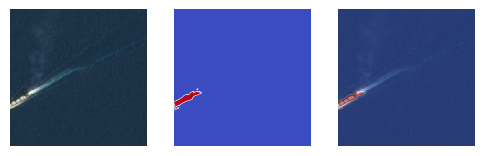

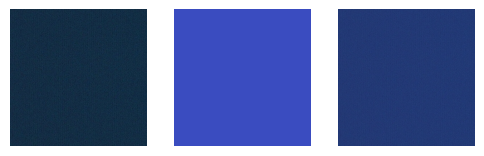

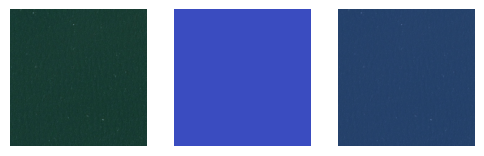

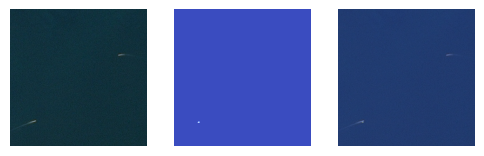

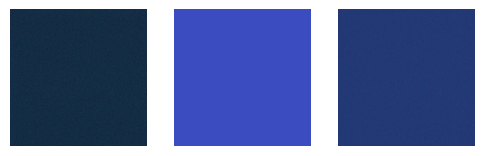

In [47]:
# make predictions for several sample images

# get random images
random_images = np.random.choice(paths, 5)  
for path in random_images:
    # predict
    y = make_prediction(images_folder + path)
    
    # plot
    plt.figure(figsize=(6,2))
    plt.subplot(131)
    plt.axis('off')
    plt.imshow(tf.keras.utils.load_img(images_folder + path))
    plt.subplot(132)
    plt.axis('off')
    plt.imshow(y, cmap='coolwarm')
    plt.subplot(133)
    plt.axis('off')
    plt.imshow(tf.keras.utils.load_img(images_folder + path))
    plt.imshow(y, cmap='coolwarm', alpha=0.4)
    plt.show()

In [ ]:
# predict test set
result = {'ImageId':[], 'EncodedPixels':[]}
for path in paths[:100]:
    y = make_prediction(images_folder + path)
    result['EncodedPixels'].append(RLE_encoder(y))
    result['ImageId'].append(path)

In [43]:
# save submission
result_df = pd.DataFrame(result)
result_df.to_csv('submission.csv', index=False)